# Diamond Prices: model tuning and evaluation

### Importing libraries

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.options.mode.chained_assignment = None
%matplotlib inline

### Loading the dataset

In [171]:
DATA_DIR = '../data'
FILE_NAME = 'diamonds.csv'
data_path = os.path.join(DATA_DIR, FILE_NAME)
diamonds = pd.read_csv(data_path)

# Evaluation metrics for regression models

### Preparing the dataset

In [174]:
## Preparation done from Chapter 2
diamonds = diamonds.loc[(diamonds['x']>0) | (diamonds['y']>0)]
diamonds.loc[11182, 'x'] = diamonds['x'].median()
diamonds.loc[11182, 'z'] = diamonds['z'].median()
diamonds = diamonds.loc[~((diamonds['y'] > 30) | (diamonds['z'] > 30))]
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['cut'], prefix='cut', drop_first=True)], axis=1)
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['color'], prefix='color', drop_first=True)], axis=1)
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['clarity'], prefix='clarity', drop_first=True)], axis=1)

## Dimensionality reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=1, random_state=123)
diamonds['dim_index'] = pca.fit_transform(diamonds[['x','y','z']])
diamonds.drop(['x','y','z'], axis=1, inplace=True)

## Metrics for regression models

### Train-test split

In [175]:
X = diamonds.drop(['cut','color','clarity','price'], axis=1)
y = diamonds['price']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

### Standarization: centering and scaling 

In [176]:
numerical_features = ['carat', 'depth', 'table', 'dim_index']
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])
X_train.loc[:, numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test.loc[:, numerical_features] = scaler.transform(X_test[numerical_features])

#### Building a simple Multiple Regression Model

In [177]:
from sklearn.linear_model import LinearRegression
ml_reg = LinearRegression()
ml_reg.fit(X_train, y_train)
y_pred = ml_reg.predict(X_test)

### Root Mean Squared Error

In [178]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_true=y_test, y_pred=y_pred)**0.5
print("RMSE: {:,.2f}".format(rmse))

RMSE: 1,085.01


### Mean Absolute Error

In [179]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
print("MAE: {:,.2f}".format(mae))

MAE: 733.67


### R-squared (R<sup>2</sup>)

In [180]:
from sklearn.metrics import r2_score
r2 = r2_score(y_true=y_test, y_pred=y_pred)
print("R-squared: {:,.2f}".format(r2))

R-squared: 0.92


In [65]:
eval_df = pd.DataFrame({"y_true": y_test, "y_pred": y_pred, "residuals": y_test - y_pred})

### Costum metric: Percentage of Predictions Within Acceptable Error

In [185]:
eval_df["prop_error"] = eval_df["residuals"].abs()/eval_df["y_true"]

In [187]:
costum_metric = 100*(eval_df["prop_error"] < 0.15).mean()
print("Costum metric: {:,.1f}%".format(costum_metric))

Costum metric: 39.2%


## Visualization methods for evaluating regression models

### Distributions of residuals

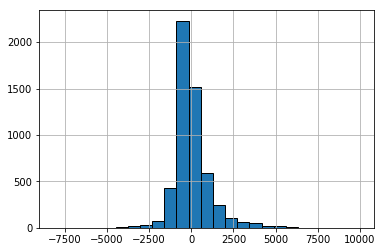

In [195]:
eval_df["residuals"].hist(bins=25, ec='k');

In [196]:
(eval_df["residuals"] <=0).mean()

0.5928054885963285

### Observed vs. predicted values plot

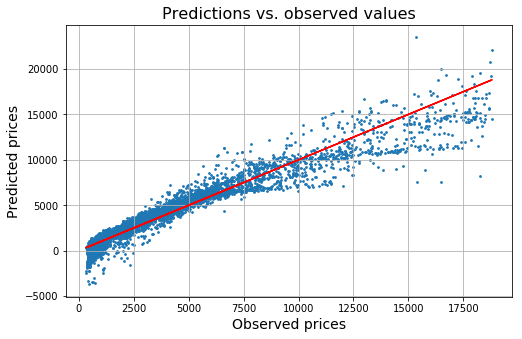

In [197]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(eval_df["y_true"], eval_df["y_pred"], s=3)
ax.plot(eval_df["y_true"], eval_df["y_true"], color='red')
ax.set_title('Predictions vs. observed values', fontsize=16)
ax.set_xlabel('Observed prices', fontsize=14)
ax.set_ylabel('Predicted prices', fontsize=14)
ax.grid();

In [198]:
eval_df["y_pred"].loc[eval_df["y_pred"]<0][:5]

39299   -312.643120
29808   -140.454585
31615   -283.365154
2714    -523.867542
5045    -569.694449
Name: y_pred, dtype: float64

### Predicted values vs. residuals

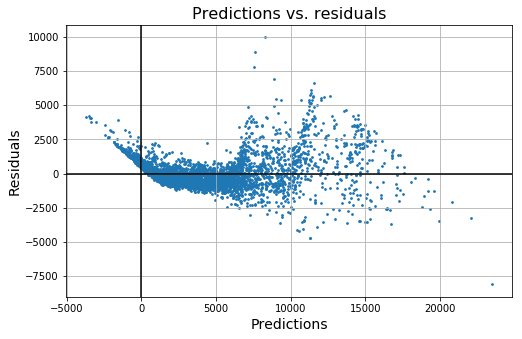

In [199]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(eval_df["y_pred"], eval_df["residuals"], s=3)
ax.set_title('Predictions vs. residuals', fontsize=16)
ax.set_xlabel('Predictions', fontsize=14)
ax.set_ylabel('Residuals', fontsize=14)
ax.axhline(color='k'); ax.axvline(color='k');
ax.grid();

## K-fold cross validation for model evaluation

In [201]:
## Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)

## Standardize the numeric features 
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])
X_train.loc[:, numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test.loc[:, numerical_features] = scaler.transform(X_test[numerical_features])

## Model training
ml_reg = LinearRegression()
ml_reg.fit(X_train, y_train)

## Get predictions
y_pred = ml_reg.predict(X_test)

## Evaluate the model using the same metric
mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
print("MAE: {:,.2f}".format(mae))

MAE: 726.87


In [225]:
from sklearn.model_selection import cross_validate, RepeatedKFold

## Scaling the whole dataset
scaler = StandardScaler()
scaler.fit(X[numerical_features])
X.loc[:, numerical_features] = scaler.fit_transform(X[numerical_features])

## 10-fold cv
ml_reg = LinearRegression()
cv_results = cross_validate(ml_reg, X, y, scoring='neg_mean_absolute_error', cv=10)
scores = -1*cv_results['test_score']
scores

array([ 720.83563282,  663.1562278 ,  695.18142822,  950.88984768,
       2043.71156001,  890.10617501,  539.98283615,  624.44948736,
        584.63334965,  604.29011263])

In [226]:
scores.mean()

831.7236657326697